In [1]:
import numpy as np
import cv2
import os
import sys
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
# detecting the faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

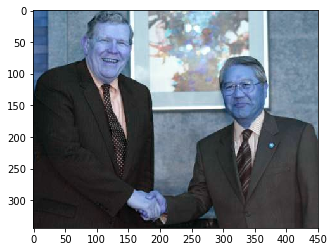

In [47]:
image_path = "13.jpg"
image = cv2.imread(image_path)
plt.imshow(image)

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

In [5]:
# now we have the faces
border = 0.25

In [56]:
face_crops = [((x - int(w * border), y - int(h * border)), \
               cv2.cvtColor(image[y - int(h * border):y+h + int(h * border), 
                                 x - int(w * border) :x+w + int(w * border)], \
                                cv2.COLOR_BGR2RGB)) for x, y, w, h  in faces]

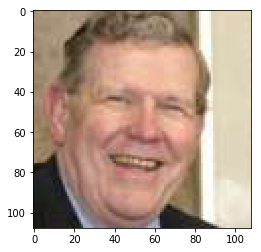

In [11]:
plt.imshow(face_crops[0])

In [9]:
from dlib_alignment import dlib_detect_face, face_recover
import torch
from PIL import Image
import torchvision.transforms as transforms
from models.SRGAN_model import SRGANModel
import numpy as np
import argparse
import utils

In [12]:
_transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                      std=[0.5, 0.5, 0.5])])

In [28]:
def get_FaceSR_opt():
    parser = argparse.ArgumentParser()
    parser.add_argument('--gpu_ids', type=str, default=None)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--lr_G', type=float, default=1e-4)
    parser.add_argument('--weight_decay_G', type=float, default=0)
    parser.add_argument('--beta1_G', type=float, default=0.9)
    parser.add_argument('--beta2_G', type=float, default=0.99)
    parser.add_argument('--lr_D', type=float, default=1e-4)
    parser.add_argument('--weight_decay_D', type=float, default=0)
    parser.add_argument('--beta1_D', type=float, default=0.9)
    parser.add_argument('--beta2_D', type=float, default=0.99)
    parser.add_argument('--lr_scheme', type=str, default='MultiStepLR')
    parser.add_argument('--niter', type=int, default=100000)
    parser.add_argument('--warmup_iter', type=int, default=-1)
    parser.add_argument('--lr_steps', type=list, default=[50000])
    parser.add_argument('--lr_gamma', type=float, default=0.5)
    parser.add_argument('--pixel_criterion', type=str, default='l1')
    parser.add_argument('--pixel_weight', type=float, default=1e-2)
    parser.add_argument('--feature_criterion', type=str, default='l1')
    parser.add_argument('--feature_weight', type=float, default=1)
    parser.add_argument('--gan_type', type=str, default='ragan')
    parser.add_argument('--gan_weight', type=float, default=5e-3)
    parser.add_argument('--D_update_ratio', type=int, default=1)
    parser.add_argument('--D_init_iters', type=int, default=0)

    parser.add_argument('--print_freq', type=int, default=100)
    parser.add_argument('--val_freq', type=int, default=1000)
    parser.add_argument('--save_freq', type=int, default=10000)
    parser.add_argument('--crop_size', type=float, default=0.85)
    parser.add_argument('--lr_size', type=int, default=128)
    parser.add_argument('--hr_size', type=int, default=512)

    # network G
    parser.add_argument('--which_model_G', type=str, default='RRDBNet')
    parser.add_argument('--G_in_nc', type=int, default=3)
    parser.add_argument('--out_nc', type=int, default=3)
    parser.add_argument('--G_nf', type=int, default=64)
    parser.add_argument('--nb', type=int, default=16)

    # network D
    parser.add_argument('--which_model_D', type=str, default='discriminator_vgg_128')
    parser.add_argument('--D_in_nc', type=int, default=3)
    parser.add_argument('--D_nf', type=int, default=64)

    # data dir
    parser.add_argument('--pretrain_model_G', type=str, default='90000_G.pth')
    parser.add_argument('--pretrain_model_D', type=str, default=None)

    args = parser.parse_args("")

    return args

In [29]:
sr_model = SRGANModel(get_FaceSR_opt(), is_train=False)
sr_model.load()

Network G structure: DataParallel - RRDBNet, with parameters: 11,662,019


In [36]:
def sr_forward(img, padding=0.5, moving=0.1):
    img_aligned, M = dlib_detect_face(img, padding=padding, image_size=img.sh, moving=moving)
    input_img = torch.unsqueeze(_transform(Image.fromarray(img)), 0)
    sr_model.var_L = input_img.to(sr_model.device)
    sr_model.test()
    output_img = sr_model.fake_H.squeeze(0).cpu().numpy()
    output_img = np.clip((np.transpose(output_img, (1, 2, 0)) / 2.0 + 0.5) * 255.0, 0, 255).astype(np.uint8)
    rec_img = face_recover(output_img, M * 4, img)
    return output_img, rec_img

In [41]:
output_img, rec_img = sr_forward(face_crops[0])

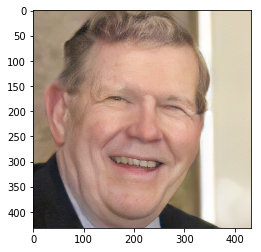

In [42]:
plt.imshow(output_img)

In [43]:
rec_img.shape

(108, 108, 3)

In [44]:
output_img.shape

(432, 432, 3)

In [71]:
new_image_bgr = cv2.resize(image, (image.shape[1] * 4, image.shape[0] * 4))

In [72]:
new_image = cv2.cvtColor(new_image_bgr, cv2.COLOR_BGR2RGB)

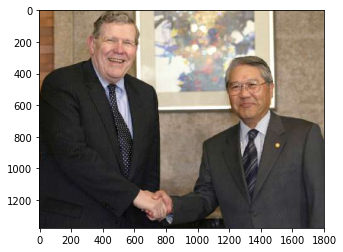

In [76]:
plt.imshow(new_image)

(71, 4, 108, 108)
(275, 77, 104, 104)


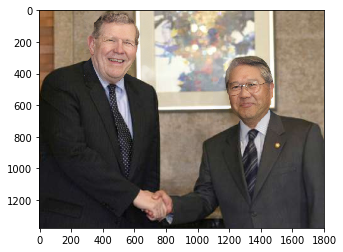

In [82]:
# plt.imshow(new_image)
new_image_bgr = cv2.resize(image, (image.shape[1] * 4, image.shape[0] * 4))
new_image = cv2.cvtColor(new_image_bgr, cv2.COLOR_BGR2RGB)

for face in face_crops:
    face_image = face[1]
    position = face[0] + (face_image.shape)[:-1]
    print(position)
    
    output_img, rec_img = sr_forward(face_image)
    new_dims = output_img.shape[:-1]
    new_image[4 * position[1]: 4 * position[1] + new_dims[1], 4 * position[0] : 4 * position[0] + new_dims[0]] = output_img

plt.imshow(new_image)

In [84]:
new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
cv2.imwrite("13-better.png", new_image)

True